This notebook shows the numerical computations in the section _Taylor Expansion of Action_.

In [1]:
import os
import numpy as np
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Reproducibility
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

2024-04-06 14:06:06.442611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape([-1, 28*28]) / 255.0
x_test = x_test.astype('float32').reshape([-1, 28*28]) / 255.0
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [3]:
def train_model(hidden_units):
    # Build model.
    layers = []
    layers.append(
        Dense(hidden_units[0])  # embedding.
    )
    for n in hidden_units[1:]:
        layers.append(Dense(n, 'silu'))
    layers.append(Dense(10))  # output.
    model = Sequential(layers)

    # Compile and train
    model.compile(
        optimizer=AdamW(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
    )
    model.fit(
        x_train, y_train,
        batch_size=2**12,
        validation_data=(x_test, y_test),
        epochs=10000,  # sufficiently great enough.
        callbacks=[
            EarlyStopping(monitor='val_loss'),
        ],
        verbose=0,
    )
    return model


def get_validation_loss(model):
    y_pred = model(x_test)
    loss_fn = SparseCategoricalCrossentropy(from_logits=True)
    return loss_fn(y_test, y_pred)


def get_training_loss(model):
    y_pred = model(x_train)
    loss_fn = SparseCategoricalCrossentropy(from_logits=True)
    return loss_fn(y_train, y_pred)


def get_num_params(hidden_units):
    num_params = 0
    # num_params += 28*28 * hidden_units[0]  # shall not add this.
    for n1, n2 in zip(hidden_units[:-1], hidden_units[1:]):
        num_params += n1 * n2
    num_params += hidden_units[-1] * 10  # this will not change the slope.
    return num_params

In [4]:
model = train_model([1024, 2048])

In [5]:
# Embedding.
z = Sequential(model.layers[:1])(x_train)
# E_p[z_a].
Z = tf.reduce_mean(z, axis=0)

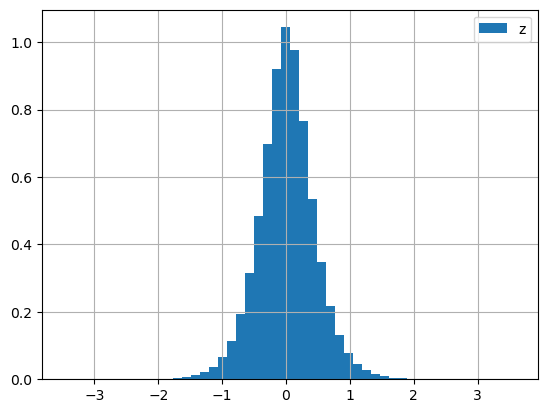

In [6]:
plt.hist(z.numpy().reshape([-1]), 50, density=True, label='z')
plt.legend()
plt.grid()
plt.show()

In [7]:
Za = []
for a in range(10):
    Za.append(
        np.take(z, np.where(y_train == a), axis=0)[0]
    )

# J_{ab}.
J2 = []
for _ in Za:
    J2.append(Z - tf.reduce_mean(_, axis=0))
J2 = tf.stack(J2, axis=0).numpy()

In [8]:
J2.shape

(10, 1024)

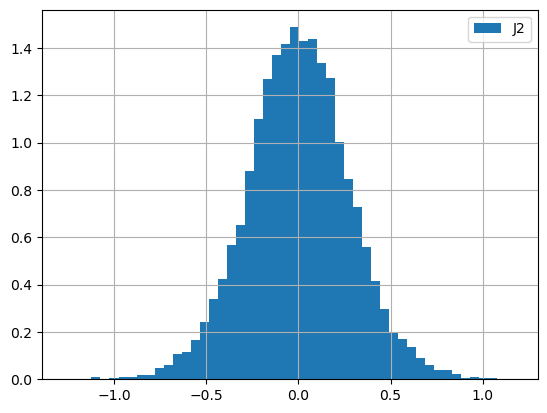

In [9]:
plt.hist(J2.reshape([-1]), 50, density=True, label='J2')
plt.legend()
plt.grid()
plt.show()

In [10]:
def tensor_product(*args):
    if len(args) == 2:
        a, b = args
        a = tf.expand_dims(a, axis=-1)
        b = tf.expand_dims(b, axis=-2)
        return a * b
    elif len(args) > 2:
        y = tensor_product(*args[:2])
        new_args = [y] + list(args[2:])
        return tensor_product(*new_args)
    else:
        raise ValueError()

In [11]:
# E_p[z_a z_b]
ZZ = tf.reduce_mean(tensor_product(z[:200], z[:200]), axis=0)
ZZ.shape

TensorShape([1024, 1024])

In [12]:
ZZa = []
for a in range(10):
    za = np.take(z, np.where(y_train == a), axis=0)[0]
    ZZa.append(
        tensor_product(za[:50], za[:50])
    )

# J_{abc}
J3 = []
for _ in ZZa:
    J3.append(ZZ - tf.reduce_mean(_, axis=0))
J3 = tf.stack(J3, axis=0).numpy()

In [13]:
J3.min(), J3.max()

(-2.2754786, 1.6594101)

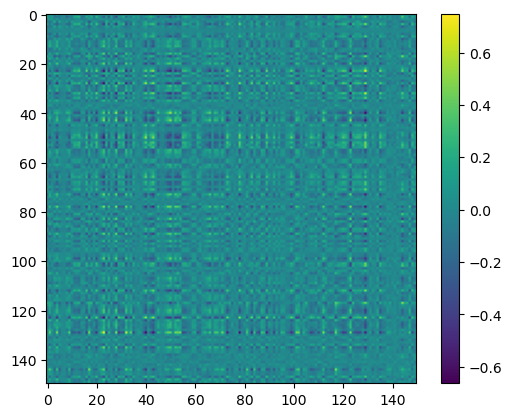

In [14]:
a = 2
plt.imshow(J3[a][:150, :150])
plt.colorbar()
plt.show()

In [15]:
# The best fit parameters: \theta_{\star}
U, c = model.layers[-1].weights
U = tf.transpose(U)
W, b = model.layers[-2].weights
W = tf.transpose(W)
U.shape, c.shape, W.shape, b.shape

(TensorShape([10, 2048]),
 TensorShape([10]),
 TensorShape([2048, 1024]),
 TensorShape([2048]))

In [16]:
# Parameters for computing S_2 and S_3.
M = U.shape[0]
Mf = tf.cast(M, tf.float32)  # float M.
I2 = tf.linalg.diag(tf.ones([M]))  # \delta_{ab}

# \delta_{abc}
I3 = np.zeros([M, M, M])
for i in range(M):
    I3[i, i, i] = 1
I3 = tf.constant(I3, dtype=tf.float32)

A2 = I2 - 1/Mf
B3 = (
    I3
    - (I2[:,:,tf.newaxis] + I2[:,tf.newaxis,:] + I2[tf.newaxis,:,:]) / Mf
    + 2 / (Mf**2)
)

def get_S0():
    """The zeroth order term."""
    return tf.math.log(Mf)

def get_S2(U, c, W):
    """The second order terms."""
    return (
        0.5 / Mf * tf.reduce_sum(A2 * tensor_product(c, c)),
        0.5 / Mf / 2 * tf.reduce_sum(J2 * tf.matmul(U, W)),
    )

def get_S3(U, c, W, b):
    """The third order terms."""
    return (
        (1/6/Mf) * tf.reduce_sum(B3 * tensor_product(c, c, c)),
        (1/12/Mf) * tf.reduce_sum(A2 * tensor_product(tf.linalg.matvec(U, b), c)),
        (1/12/Mf) * tf.reduce_sum(tensor_product(A2, Z) * tensor_product(c, tf.matmul(U, W))),
        (1/12/Mf) * tf.reduce_sum(J2 * tf.einsum('ab,bc,b->ac', U, W, b)),
        (1/12/Mf) * tf.reduce_sum(J3 * tf.einsum('ab,bc,bd->acd', U, W, W)),
    )

In [17]:
get_S2(U, c, W)

(<tf.Tensor: shape=(), dtype=float32, numpy=4.8317135e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-5.896573>)

In [18]:
get_S3(U, c, W, b)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9564354e-07>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00018122264>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00073869346>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.00012417475>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8061678>)

In [19]:
def get_loss(U, c, W, b):
    """The final perturbative loss."""
    loss = get_S0()
    for term in get_S2(U, c, W):
        loss += term
    for term in get_S3(U, c, W, b):
        loss += term
    return loss

In [20]:
get_loss(U, c, W, b)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.7869759>

In [21]:
get_training_loss(model).numpy()

0.36388737